In [1]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import os

# 디버깅을 위한 프로젝트명을 기입합니다.
os.environ["LANGCHAIN_PROJECT"] = "RAG Base"

# tracing 을 위해서는 아래 코드의 주석을 해제하고 실행합니다.
os.environ["LANGCHAIN_TRACING_V2"] = 'true'

## document retriever

In [122]:
from tqdm.notebook import tqdm

import pprint
import bs4

from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain.prompts import PromptTemplate

from typing import List
from typing_extensions import TypedDict

from abc import ABC, abstractmethod
from operator import itemgetter

In [ ]:
# from rag.utils import format_docs, format_searched_docs

In [270]:
model_name="gemma2:2b"
embd = OllamaEmbeddings(model=model_name)
llm = ChatOllama(model=model_name, temperature=0)

In [271]:
doc_path = "data/Retrieval-augmented generation - Wikipedia.pdf"
loader = PyPDFLoader(doc_path)
docs = loader.load()

In [274]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splits = text_splitter.split_documents(docs)

In [275]:
vectorstore = None
for d in tqdm(splits):
    if vectorstore:
        vectorstore.add_documents([d])
    else:
        vectorstore = FAISS.from_documents(
            documents=[d], 
            embedding=embd
        )

  0%|          | 0/13 [00:00<?, ?it/s]

In [276]:
doc_name = doc_path.split('data/')[-1].split('.pdf')[0].replace(' ', '_')
doc_name

'Retrieval-augmented_generation_-_Wikipedia'

In [277]:
faiss_path = f"data/faiss_{model_name.replace(':','-')}_{doc_name}"
faiss_path

'data/faiss_gemma2-2b_Retrieval-augmented_generation_-_Wikipedia'

In [279]:
vectorstore.save_local(faiss_path)

In [280]:
vectorstore = FAISS.load_local(faiss_path, embd, allow_dangerous_deserialization=True)

In [281]:
retriever = vectorstore.as_retriever(
    search_type="mmr", search_kwargs={"k": 5}
)

## LLMs

In [282]:
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    # 검색한 문서 결과를 하나의 문단으로 합쳐줍니다.
    return "\n\n".join(doc.page_content for doc in docs)

# 체인을 생성합니다.
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is RAG process?")

'RAG stands for Retrieval-Augmented Generation, which combines external documents with user input to generate tailored outputs using Large Language Models (LLMs).  The process involves retrieving relevant documents using a retriever, then feeding this information into an LLM prompt for further processing and output generation. \n'

### A: Retrieval Grader

In [283]:
### Retrieval Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary flag 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary flag as a JSON with a single key 'flag' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'flag': 'yes'}


In [304]:
retriever.get_relevant_documents("What is Self-RAG?")

[Document(metadata={'source': 'data/Retrieval-augmented generation - Wikipedia.pdf', 'page': 0}, page_content='a generation phase. [1]\nedit\nThe data t o be r eferenced must fir st be conv erted int o LLM , numerical\nrepresentations in the for m of large vectors. RAG can be used on unstructur ed (usually t ext),\nsemi-structur ed, or structur ed data (for example ). These embeddings ar e\nthen st ored in a  to allow for .embeddings\nknowledge graphs [1]\nvector datab ase document r etrieval\nOverview of RAG process, combining external documents and user input into an LLM prompt to get\ntailored output\nedit\nGiven a user quer y, a document r etriever is fir st called t o select the most r elevant documents\nwhich will be used t o augment the quer y. This comp arison can be done using a v ariety o f\nmethods, which depend in p art on the type o f indexing used.[3]\n[1]'),
 Document(metadata={'source': 'data/Retrieval-augmented generation - Wikipedia.pdf', 'page': 4}, page_content='RLH

In [284]:
retrieved_docs = retriever.get_relevant_documents(question)

for item in retrieved_docs:
    print(f"{item.page_content}\n")

so. The mor e reproducible v ersion is called R etro++ and includes in-cont ext RA G.[13]
edit
Converting domain data int o vectors should be done thoughtfully . It is naiv e to conv ert an
entire document int o a single v ector and expect the r etriever to find details in that document
in response t o a quer y. There are various strat egies on how t o break up the data. This is
called Chunking.
Three types o f chunking strat egies ar e:

Jump up t o: ab"What is RA G? - R etrieval-Augment ed Generation AI Explained - A WS"
Jump up t o: ab"Next-Gen Lar ge Language Models: The R etrieval-Augment ed
Generation (RA G) Handbook"
^
"Retrieval-Augment ed Generation for Knowledge-Int ensive NLP T asks"
arXiv2005.11401
^"faiss" GitHub
^ ""ColBER T: Efficient and Effectiv e Passage Sear ch
via Cont extualized Lat e Interaction ov er BER T""
^
""SPLADE v2: Sp arse Lexical and Exp ansion Model for Infor mation R etrieval""
^ ""Latent Retrieval for W eakly
Super vised Open Domain Question Answ erin

### Generate

In [285]:
### Generate

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOllama(model=model_name, temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

RAG (Retrieval-Augmented Generation) is a process that combines external documents with user input to generate tailored outputs using Large Language Models (LLMs).  It involves retrieving relevant documents using a retriever, then feeding this information into an LLM prompt for further processing.  The output is generated based on both the query and the retrieved document content. 



### Hallucination Grader

In [286]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary flag 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary flag as a JSON with a single key 'flag' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'flag': 'yes'}

### Answer Grader

In [287]:
### Answer Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary flag 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary flag as a JSON with a single key 'flag' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'flag': 'yes'}

### Question Re-writer

In [288]:
### Question Re-writer

# LLM
llm = ChatOllama(model=model_name, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'**Improved Question:**\n\nHow does the Recursive Attention-based Graph (RAG) model work? \n\n\n**Explanation of Improvements:**\n\n* **Specificity:**  The improved question focuses on the core functionality of RAG, specifically "how it works." This is more relevant for vectorstore retrieval than a general definition.\n* **Keywords:** The use of terms like "Recursive Attention" and "Graph" helps to ensure that the search query aligns with the specific data structure and processing techniques used in RAG models. \n* **Clarity:**  The question is concise and easy to understand, making it more likely to be accurately interpreted by a vectorstore system.\n\n\n**Why this works for Vectorstore Retrieval:**\n\nVectorstores are designed to efficiently store and retrieve information based on semantic similarity.  A well-structured query that includes relevant keywords helps the vectorstore system:\n\n* **Identify similar documents:** The improved question uses terms that are likely to be presen

## LangGraph

In [320]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    retriever: FAISS

### Nodes

In [321]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("\n>>> A _ RETRIEVE <<<\n")
    question = state["question"]
    retriever = state["retriever"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    print(f"\t> Retrived Documents: {len(documents)}")
    return {"documents": documents, "question": question}

In [291]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("\n>>> C _ GENERATE <<<\n")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    print(f"\t> Generation: {generation}")
    return {"documents": documents, "question": question, "generation": generation}

In [292]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print(f"\n{'-----' * 10}\n")
    print("\n>>> B _ GRADE DOCUMENT: CHECK DOCUMENT RELEVANCE TO QUESTION <<<\n")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for index, d in enumerate(documents):
        print(f"\t> CHECK DOCUMENT {index}")
        
        for i in range(3):
            
            flag = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            print(f"\t...Flag: {flag}")
            
            try:
                grade = flag["flag"]
                break
                
            except:
                print(f"\t...RETRY - {i+1}")
        
        if grade == "yes":
            print("\t...DOCUMENT RELEVANT\n")
            filtered_docs.append(d)
            
        else:
            print("\t...DOCUMENT NOT RELEVANT\n")
            continue
    
    return {"documents": filtered_docs, "question": question}

In [293]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print(f"\n{'-----' * 10}\n")
    print("\n>>> D _ TRANSFORM QUERY <<<\n")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print(f"\t> Better Question: {better_question}")
    return {"documents": documents, "question": better_question}

In [322]:
def websearch(state):

    web_path = "https://en.wikipedia.org/wiki/Black-throated_loon"
    file_path = web_path.split('https://')[-1].replace('.','-').replace('/','_')
    
    loader = WebBaseLoader(
        web_paths=(web_path,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                "div",
                attrs={"class": ["mw-content-ltr mw-parser-output"]},
            )
        ),
    )
    docs = loader.load()
    # print(f"문서의 수: {len(docs)}")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    splits = text_splitter.split_documents(docs)

    vectorstore = None
    for d in tqdm(splits):
        if vectorstore:
            vectorstore.add_documents([d])
        else:
            vectorstore = FAISS.from_documents(
                documents=[d], 
                embedding=embd
            )
            
    vectorstore.save_local(file_path)

    retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 5}
    )
    
    return {"retriever": retriever}

### Edges

In [323]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print(f"\n{'-----' * 10}\n")
    print("\n>>> CONDITIONAL: ASSESS GRADED DOCUMENTS <<<\n")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "\t> ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY. <GO TO D>"
        )
        return "Go to E _ Web Search"
    else:
        # We have relevant documents, so generate answer
        print("\t> GENERATE. <GO TO A>")
        return "Go to C _ Generate"

In [324]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print(f"\n{'-----' * 10}\n")
    print("\n\n>>> CONDITIONAL: CHECK HALLUCINATIONS <<<\n")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    flag = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = flag["flag"]

    # Check hallucination
    if grade == "yes":
        # print("> GENERATION IS GROUNDED IN DOCUMENTS")
        # Check question-answering
        # print("---GRADE GENERATION vs QUESTION---")
        flag = answer_grader.invoke({"question": question, "generation": generation})
        print(f"\t> HALLUCINATION GRADER: {flag}")
        
        grade = flag["flag"]
        if grade == "yes":
            print("\t...<USEFUL> GENERATION ADDRESSES QUESTION.")
            return "useful"
        else:
            print("\t...<NOT USEFUL> GENERATION DOES NOT ADDRESS QUESTION.")
            return "not useful"
    else:
        print("\t...<NOT SUPPORTED> GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY.")
        return "not supported"

## Build Graph

In [325]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("A _ Retrieve", retrieve)  # retrieve
workflow.add_node("B _ Grade Documents", grade_documents)  # grade documents
workflow.add_node("C _ Generate", generate)  # generatae
workflow.add_node("D _ Transform Query", transform_query)  # transform_query
workflow.add_node("E _ Web Search", websearch)

# Build graph
workflow.add_edge(START, "A _ Retrieve")
workflow.add_edge("A _ Retrieve", "B _ Grade Documents")
workflow.add_edge("D _ Transform Query", "A _ Retrieve")
workflow.add_edge("E _ Web Search", "A _ Retrieve")

workflow.add_conditional_edges(
    "B _ Grade Documents",
    decide_to_generate,
    {
        "Go to E _ Web Search": "E _ Web Search",
        "Go to C _ Generate": "C _ Generate",
    },
)
workflow.add_conditional_edges(
    "C _ Generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "C _ Generate",
        # "not supported": END,
        "useful": END,
        "not useful": "D _ Transform Query",
    },
)

# Compile
app = workflow.compile()

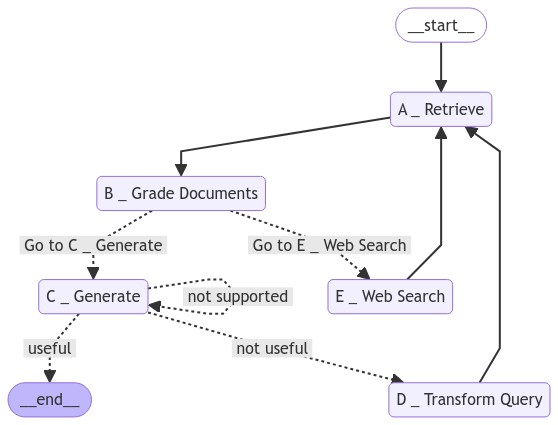

In [313]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [ ]:
from pprint import pprint

# Run
# inputs = {"question": "Explain how to process in Retrieval Augmented Generation?"}
# inputs = {"question": "What is LangGraph framework and how does it work?"}
inputs = {
    "question": "Where are Black-throated loons typically found?",
    "retriever": retriever
}
for output in app.stream(inputs):
    print(f"\n{'=====' * 15}\n")
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print(f"\n{'=====' * 15}\n")


>>> A _ RETRIEVE <<<

	> Retrived Documents: 5


Node 'A _ Retrieve':



--------------------------------------------------


>>> B _ GRADE DOCUMENT: CHECK DOCUMENT RELEVANCE TO QUESTION <<<

	> CHECK DOCUMENT 0
	...Flag: {'flag': 'no'}
	...DOCUMENT NOT RELEVANT

	> CHECK DOCUMENT 1
	...Flag: {'flag': 'no'}
	...DOCUMENT NOT RELEVANT

	> CHECK DOCUMENT 2
	...Flag: {'flag': 'no'}
	...DOCUMENT NOT RELEVANT

	> CHECK DOCUMENT 3
	...Flag: {'flag': 'no'}
	...DOCUMENT NOT RELEVANT

	> CHECK DOCUMENT 4
	...Flag: {'flag': 'no'}
	...DOCUMENT NOT RELEVANT


--------------------------------------------------


>>> CONDITIONAL: ASSESS GRADED DOCUMENTS <<<

	> ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY. <GO TO D>


Node 'B _ Grade Documents':




  0%|          | 0/39 [00:00<?, ?it/s]

In [306]:
# Final generation
pprint(value["generation"])

('Self-RAG is a framework for using large language models (LLMs) to generate '
 'text by combining external documents and user input. It works by retrieving '
 'relevant documents from an external source, then augmenting the LLM prompt '
 'with this information to produce more tailored outputs.  \n')
